In [1]:
import pandas as pd
import os

In [2]:
result_dir = '../results/ids-dataset'

In [3]:
train_df = pd.read_parquet(os.path.join(result_dir,"cicids2017_traindf.parquet"))
test_df = pd.read_parquet(os.path.join(result_dir,"cicids2017_testdf.parquet"))

In [4]:
from utils import *

In [5]:
train_df_bn = set_binary_label(train_df,label_col='Label', default_class='Benign',return_col=False)
test_df_bn = set_binary_label(test_df,label_col='Label', default_class='Benign',return_col=False)

In [6]:
lab_dic, lab_name = cluster_labels_2017()

{'Web Attack \x96 Brute Force': 0, 'Web Attack \x96 XSS': 0, 'Web Attack \x96 Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 4, 'DoS Hulk': 5, 'DoS GoldenEye': 6, 'PortScan': 7, 'FTP-Patator': 8, 'SSH-Patator': 9}


In [7]:
train_mul= set_multiple_label(train_df,label_col='Label', label_dic = lab_dic, return_col=False)
test_mul = set_multiple_label(test_df,label_col='Label', label_dic = lab_dic, return_col=False)

drop Benign
drop Infiltration
drop Heartbleed
original instances:  1040360
drop intances:  751106
after drop:  289254
drop Benign
drop Infiltration
drop Heartbleed
original instances:  260090
drop intances:  187670
after drop:  72420


# binary classification

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
st_scaler_bn = StandardScaler()

In [10]:
trainx = train_df_bn.loc[:,train_df.columns!='Label']
trainy = train_df_bn['Label']
testx = test_df_bn.loc[:,test_df.columns!='Label']
testy = test_df_bn['Label']

In [11]:
trainx_st = st_scaler_bn.fit_transform(trainx)
testx_st = st_scaler_bn.transform(testx)

In [12]:
from sklearn.linear_model import LogisticRegression

In [13]:
lr_clf = LogisticRegression()

In [14]:
lr_clf.fit(trainx_st, trainy.values)

/home/saerom/.pyenv/versions/osrnn/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
lr_clf.score(testx_st, testy)

0.9547964166250145

In [16]:
import pickle
with open('../results/ids-dataset/cicids2017_LR_binary2.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)

In [16]:
from sklearn.metrics import roc_curve, auc

predy = lr_clf.predict_proba(testx_st)
pos_label = 1 # 1 or 0
fpr, tpr, thresholds = roc_curve(testy.values, predy[:,pos_label], pos_label=pos_label)
roc_auc = auc(fpr, tpr)

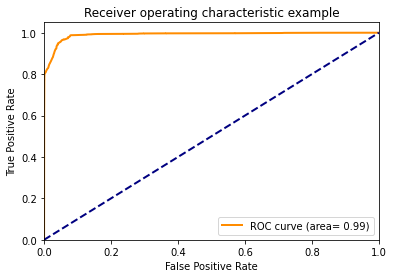

In [17]:
import matplotlib.pyplot as plt

lw=2
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=lw, label ="ROC curve (area= %.2f)"%roc_auc)
plt.plot([0,1],[0,1], color = "navy", lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# multi-class classification

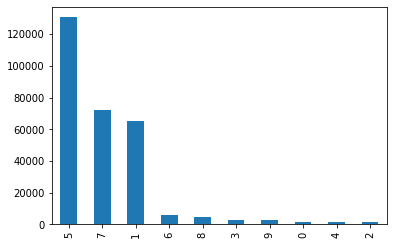

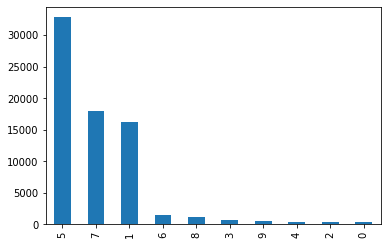

In [18]:
train_mul['Label'].value_counts().plot(kind='bar')
plt.show()
test_mul['Label'].value_counts().plot(kind='bar')
plt.show()

In [19]:
trainx_m = train_mul.loc[:,train_mul.columns!='Label']
trainy_m = train_mul['Label']
testx_m = test_mul.loc[:,test_mul.columns!='Label']
testy_m = test_mul['Label']

In [20]:
st_scaler_mul = StandardScaler()

In [21]:
trainx_m_st = st_scaler_mul.fit_transform(trainx_m)
testx_m_st = st_scaler_mul.transform(testx_m)

In [22]:
lr_clfm = LogisticRegression()

In [23]:
lr_clfm.fit(trainx_m_st, trainy_m)

/home/srp/.pyenv/versions/torchnlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [24]:
lr_clfm.score(testx_m_st, testy_m)

0.9990886495443247

In [25]:
def apply_clf_with_scaler(clf, scaler, df_x, prob = False):
    df_x_st = scaler.transform(df_x)
    if prob:
        return clf.predict_proba(df_x_st)
    else:
        return clf.predict(df_x_st)
def score_clf_with_scaler(clf, scaler, df_x, df_y):
    df_x_st = scaler.transform(df_x)
    return clf.score(df_x_st, df_y)

# evaluate multi-class model

In [26]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [27]:
predy_m = lr_clfm.predict_proba(testx_m_st)

In [28]:
pred_m = lr_clfm.predict(testx_m_st)

/home/srp/.pyenv/versions/torchnlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


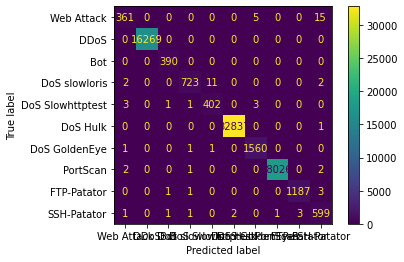

In [29]:
plot = plot_confusion_matrix(lr_clfm, # 분류 모델
                             testx_m_st, testy_m, # 예측 데이터와 예측값의 정답(y_true)
                             display_labels=lab_name, # 표에 표시할 labels
#                              cmap=plt.cm.Blue, # 컬러맵(plt.cm.Reds, plt.cm.rainbow 등이 있음)
                             normalize=None) # 'true', 'pred', 'all' 중에서 지정 가능. default=None

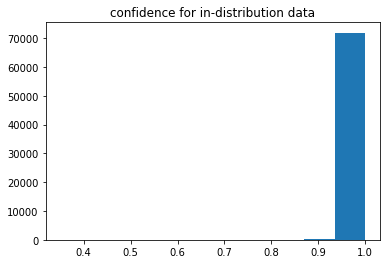

In [30]:
plt.hist(np.max(predy_m,axis=1))
plt.title("confidence for in-distribution data")
plt.show()

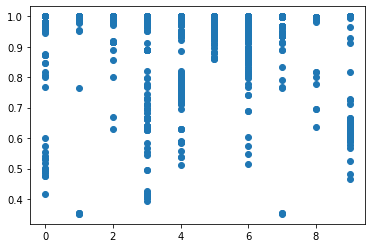

In [31]:
plt.scatter(pred_m,np.max(predy_m,axis=1))
plt.show()

In [32]:
ooc_col = 'SSH-Patator' # 'SSH-Patator', 'Heartbleed', 'Benign', 'Infiltration'
ooc_idx = (train_df['Label']==ooc_col)
train_ooc = train_df.loc[ooc_idx]
train_ooc = train_ooc.loc[:,train_ooc.columns!='Label']

In [33]:
train_ooc.shape

(2597, 67)

In [34]:
pred_ooc = apply_clf_with_scaler(lr_clfm, st_scaler_mul, train_ooc, prob = False)
prob_ooc = apply_clf_with_scaler(lr_clfm, st_scaler_mul, train_ooc, prob = True)

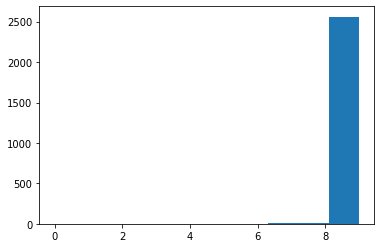

In [35]:
plt.hist(pred_ooc)
plt.show()

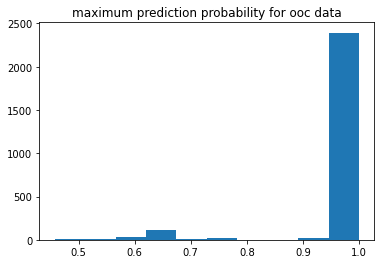

In [36]:
plt.hist(np.max(prob_ooc,axis=1))
plt.title("maximum prediction probability for ooc data")
plt.show()

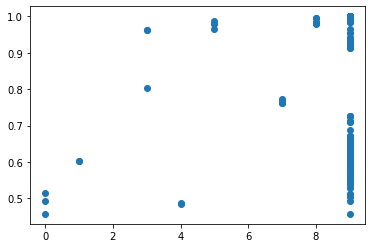

In [37]:
plt.scatter(pred_ooc,np.max(prob_ooc,axis=1),)
plt.show()